# Activity 7: Optimizing a deep learning model
In this activity we optimize our deep learning model. We aim to achieve greater performance than our model `bitcoin_lstm_v0`, which is off at about 6.8% from the real Bitcoin prices. We explore the following topics in this notebook:

* Experimenting with different layers and the number of nodes
* Grid search strategy for epoch and activation functions

## Load Data

In [1]:
%autosave 5

#  Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

from datetime import datetime, timedelta
from keras.models import load_model, Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout, ActivityRegularization
from keras.callbacks import TensorBoard

from scripts.utilities_activity7 import (
    create_groups, split_lstm_input, 
    train_model, plot_two_series, rmse, 
    mape, denormalize)

np.random.seed(0)

Autosaving every 5 seconds


In [2]:
#  Load datasets
train = pd.read_csv('/content/train_dataset.csv')
test = pd.read_csv('/content/test_dataset.csv')

In [3]:
#  Convert `date` column to datetime type
test['date'] = test['date'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [4]:
#  Group data into groups containing seven observations
train_data = create_groups(
    train['close_point_relative_normalization'][2:].values)
test_data = create_groups(
    test['close_point_relative_normalization'][:-3].values)

In [5]:
#  Reshape the data in the format expected by the LSTM layer
X_train, Y_train = split_lstm_input(train_data)

## Reference Model

In [8]:
#  TASK:
#  Load data for `v0` of our model.
#  Call this `model_v0`.
model_v0= load_model('bitcoin_lstm_v0.h5')

In [10]:
%%time

#  TASK:
#  Train the reference model `model_v0`.
#
history = model_v0.fit(
    x=X_train, y=Y_train,
    batch_size=32, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 9.3836e-04
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 8.5599e-04
Epoch 13/100
1/1 [==============================] - 0

## Adding Layers and Nodes

In [11]:
#  Initialize variables
period_length = 7
number_of_periods = 76
batch_size = 1

In [12]:
#  Model 1: two LSTM layers
model_v1 = Sequential()

model_v1.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))   # note return_sequences is now true

#  TASK:
#  Add new LSTM layer to this network here.
#
model_v1.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v1.add(Dense(units=period_length))
model_v1.add(Activation("linear"))

model_v1.compile(loss="mse", optimizer="rmsprop")

In [13]:
%%time
train_model(model=model_v1, X=X_train, Y=Y_train, epochs=100, version=1, run_number=0)

Epoch 1/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0030
Epoch 2/100
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 3/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0020
Epoch 4/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 5/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0016
Epoch 6/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0015
Epoch 7/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0014
Epoch 8/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 9/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 10/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 9.7342e-04
Epoch 12/100
1/1 [==============================] - 0s 5ms/s

## Epochs

In [14]:
# Model 2: two LSTM layers, trained for 300 epochs
model_v2 = Sequential()

model_v2.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

model_v2.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v2.add(Dense(units=period_length))
model_v2.add(Activation("linear"))

model_v2.compile(loss="mse", optimizer="rmsprop")

In [15]:
%%time

#  TASK:
#  Change the number of epochs below
#  to 300 and evaluate the results on TensorBoard.
#
train_model(model=model_v2, X=X_train, Y=Y_train, epochs=300, version=2, run_number=0)

Epoch 1/300
1/1 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 2/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0020
Epoch 3/300
1/1 [==============================] - 0s 9ms/step - loss: 0.0016
Epoch 4/300
1/1 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 5/300
1/1 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 6/300
1/1 [==============================] - 0s 9ms/step - loss: 8.9453e-04
Epoch 7/300
1/1 [==============================] - 0s 9ms/step - loss: 7.4686e-04
Epoch 8/300
1/1 [==============================] - 0s 9ms/step - loss: 6.2304e-04
Epoch 9/300
1/1 [==============================] - 0s 10ms/step - loss: 5.1864e-04
Epoch 10/300
1/1 [==============================] - 0s 10ms/step - loss: 4.3032e-04
Epoch 11/300
1/1 [==============================] - 0s 10ms/step - loss: 3.5555e-04
Epoch 12/300
1/1 [==============================] - 0s 4ms/step - loss: 2.9226e-04
Epoch 13/300
1/1 [===========

## Activation Functions

In [19]:
# Model 3: two LSTM layers, trained for 300 epochs,
#          tanh activation function
model_v3 = Sequential()

model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v3.add(Dense(units=period_length))

#  TASK:
#  Change the activation function
#  from "linear" to "tanh".
#
model_v3.add(Activation("tanh"))

model_v3.compile(loss="mse", optimizer="rmsprop")

In [20]:
%%time
train_model(model=model_v3, X=X_train, Y=Y_train, epochs=300, version=3, run_number=0)

Epoch 1/300
1/1 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 2/300
1/1 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 3/300
1/1 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 4/300
1/1 [==============================] - 0s 11ms/step - loss: 9.3218e-04
Epoch 5/300
1/1 [==============================] - 0s 6ms/step - loss: 6.9170e-04
Epoch 6/300
1/1 [==============================] - 0s 8ms/step - loss: 5.2271e-04
Epoch 7/300
1/1 [==============================] - 0s 9ms/step - loss: 4.0099e-04
Epoch 8/300
1/1 [==============================] - 0s 9ms/step - loss: 3.1049e-04
Epoch 9/300
1/1 [==============================] - 0s 11ms/step - loss: 2.4161e-04
Epoch 10/300
1/1 [==============================] - 0s 10ms/step - loss: 1.8814e-04
Epoch 11/300
1/1 [==============================] - 0s 9ms/step - loss: 1.4605e-04
Epoch 12/300
1/1 [==============================] - 0s 9ms/step - loss: 1.1271e-04
Epoch 13/300
1/1 [====

## Regularization Strategies

In [22]:
model_v4 = Sequential()
model_v4.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

#  TASK:
#  Implement a Dropout() here.
#

model_v4.add(Dropout(0.2))
model_v4.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

#  TASK:
#  Implement a Dropout() here too.
#
model_v4.add(Dropout(0.2))

model_v4.add(Dense(units=period_length))
model_v4.add(Activation("tanh"))

model_v4.compile(loss="mse", optimizer="rmsprop")

In [23]:
%%time
train_model(model=model_v4, X=X_train, Y=Y_train, epochs=600, version=4, run_number=0)

Epoch 1/600
1/1 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 2/600
1/1 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 3/600
1/1 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 4/600
1/1 [==============================] - 0s 9ms/step - loss: 0.0011
Epoch 5/600
1/1 [==============================] - 0s 4ms/step - loss: 7.2626e-04
Epoch 6/600
1/1 [==============================] - 0s 8ms/step - loss: 6.8822e-04
Epoch 7/600
1/1 [==============================] - 0s 6ms/step - loss: 8.3544e-04
Epoch 8/600
1/1 [==============================] - 0s 9ms/step - loss: 5.4894e-04
Epoch 9/600
1/1 [==============================] - 0s 6ms/step - loss: 3.9558e-04
Epoch 10/600
1/1 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 11/600
1/1 [==============================] - 0s 4ms/step - loss: 6.0169e-04
Epoch 12/600
1/1 [==============================] - 0s 2ms/step - loss: 1.7880e-04
Epoch 13/600
1/1 [===============

## Evaluate Models

In [24]:
combined_set = np.concatenate((train_data, test_data), axis=1)

def evaluate_model(model, kind='series'):
    """Compute the MSE for all future weeks in period.
    
    Parameters
    ----------
    model: Keras trained model
    
    kind: str, default 'series'
        Kind of evaluation to perform. If 'series', 
        then the model will perform an evaluation 
        over the complete series.
    
    Returns
    -------
    evaluated_weeks: list
        List of MSE values for each evaluated
        test week.
    """
    if kind == 'series':
        predicted_weeks = []
        for i in range(0, test_data.shape[1]):
            input_series = combined_set[0:,i:i+76]
            predicted_weeks.append(model.predict(input_series))

        predicted_days = []
        for week in predicted_weeks:
            predicted_days += list(week[0])

        return predicted_days
    else:
        evaluated_weeks = []
        for i in range(0, test_data.shape[1]):
            input_series = combined_set[0:,i:i+77]

            X_test = input_series[0:,:-1].reshape(1, input_series.shape[1] - 1, 7)
            Y_test = input_series[0:,-1:][0]

            result = model.evaluate(x=X_test, y=Y_test, verbose=0)
            evaluated_weeks.append(result)
            
            return evaluated_weeks


In [25]:
def plot_weekly_mse(series, model_name, color):
    """Plot weekly MSE."""
    ax = pd.Series(series).plot(drawstyle="steps-post",
                                figsize=(14,4),
                                color=color,
                                grid=True,
                                label=model_name,
                                alpha=0.7,
                                title='Mean Squared Error (MSE) for Test Data (all models)'.format(
                                       model_name))

    ax.set_xticks(range(0, len(series)))
    ax.set_xlabel("Predicted Week")
    ax.set_ylabel("MSE")

    return ax

In [26]:
def plot_weekly_predictions(predicted_days, name, display_plot=True, 
                            variable='close'):
    """Plot weekly predictions and calculate RMSE and MAPE."""
    
    # Create dataframe to store predictions and associated dates
    last_day = datetime.strptime(train['date'].max(), '%Y-%m-%d')
    list_of_days = []
    for days in range(1, len(predicted_days) + 1):
        D = (last_day + timedelta(days=days)).strftime('%Y-%m-%d')
        list_of_days.append(D)
    
    predicted = pd.DataFrame({
        'date': list_of_days,
        'close_point_relative_normalization': predicted_days
    })
    
    # Convert `date` variable to datetime
    predicted['date'] = predicted['date'].apply(
        lambda x: datetime.strptime(x, '%Y-%m-%d'))

    # Create iso_week column in `predicted` dataframe
    predicted['iso_week'] = predicted['date'].apply(
        lambda x: x.strftime('%Y-%U'))

    # Denormalize predictions
    predicted_close = predicted.groupby('iso_week').apply(
        lambda x: denormalize(test[:-3], x))

    # Plot denormalized predictions and observed values
    plot_two_series(test[:-3], predicted_close,
                    variable=variable,
                    title=f'{name}: Predictions per Week')
    
    # Calculate RMSE and MAPE
    print(f'RMSE: {rmse(test[:-3][variable], predicted_close[variable]):.2f}')
    print(f'MAPE: {mape(test[:-3][variable], predicted_close[variable]):.2f}%')

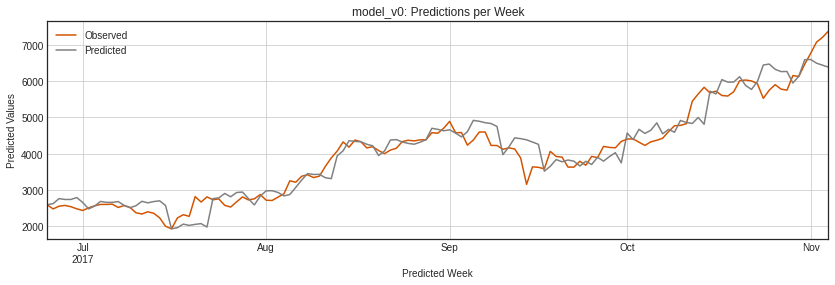

RMSE: 352.16
MAPE: 6.77%


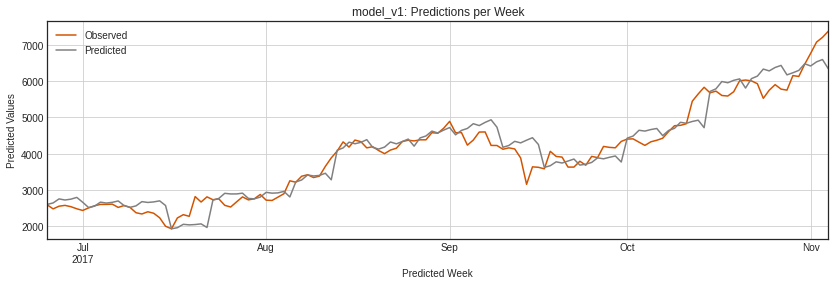

RMSE: 346.96
MAPE: 6.43%


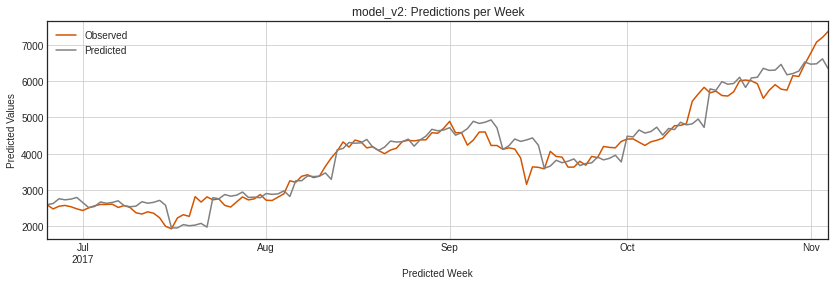

RMSE: 347.16
MAPE: 6.48%


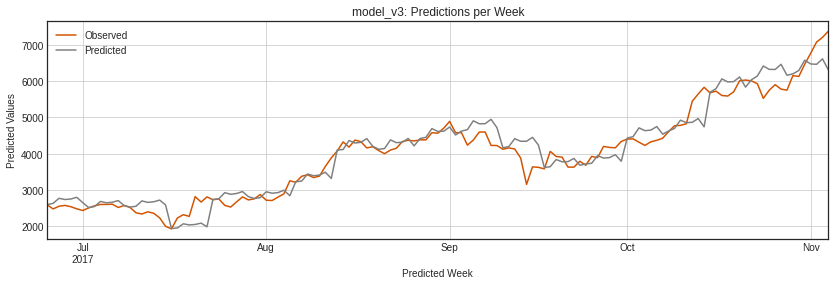

RMSE: 351.29
MAPE: 6.61%


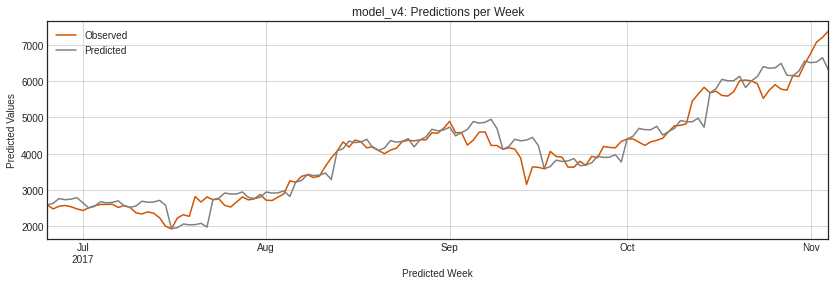

RMSE: 351.71
MAPE: 6.51%


In [27]:
#  Evaluate each model trained in this activity in sequence
models = [model_v0, model_v1, model_v2, model_v3, model_v4]
for i, M in enumerate(models):
    predicted_days = evaluate_model(M, kind='series')
    plot_weekly_predictions(predicted_days, f'model_v{i}')